In [1]:
from keras.models import load_model
import pandas as pd
import numpy as np
from PIL import Image,ImageOps
import CharacterSegmentation as cs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os

Using TensorFlow backend.


In [2]:
INPUT_IMAGE = './input/input.jpg'
SEGMENTED_OUTPUT_DIR = './segmented/'
EMNIST_PATH = './data/emnist/'
MODEL_PATH = './model/alphanum_model_binary_ex_88.h5'
mapping_processed = EMNIST_PATH + 'processed-mapping.csv'

## Character Segmentation

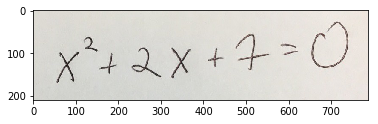

In [3]:
img = Image.open(INPUT_IMAGE)
plt.imshow(img)

In [4]:
cs.image_segmentation(INPUT_IMAGE)


........Program Initiated.......


 Resizing Image........
#---------Image Info:--------#
	Height = 352 
	Width = 1320
#----------------------------#
Applying Adaptive Threshold with kernel :- 21 X 21
Noise Removal From Image.........
Beginning Character Semenation..............

Given Text has   #  1  #   no. of lines

Average Width of Each Letter:-  87.2


In [5]:
segmented_images = []
files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]
for f in files:
    segmented_images.append(Image.open(SEGMENTED_OUTPUT_DIR + f))

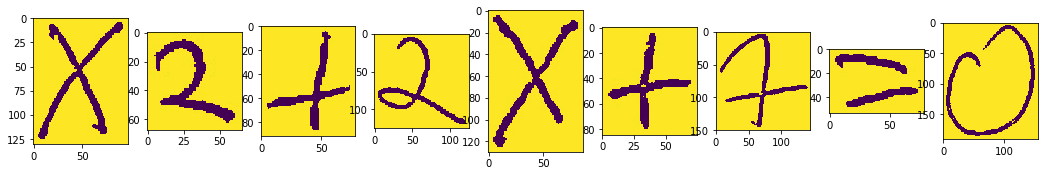

In [6]:
figure(figsize=(18,18))

size = len(segmented_images)
for i in range(size):
    img = segmented_images[i]
    plt.subplot(2, size, i + 1)
    plt.imshow(img)

## Making images bolder to avoid artifacts on resizing

In [7]:
import cv2
import numpy as np

files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]
for f in files:
    filename = SEGMENTED_OUTPUT_DIR + f
    img = cv2.imread(filename, 0)

    kernel = np.ones((2,2), np.uint8)
    dilation = cv2.erode(img, kernel, iterations = 1)
    cv2.imwrite(filename, dilation)

## Converting Segmented Characters to EMNIST format

In [8]:
def img2emnist(filepath, char_code):
    img = Image.open(filepath).resize((28, 28))
    inv_img = ImageOps.invert(img)
    
    flatten = np.array(inv_img).flatten()
    flatten = flatten / 255
    flatten = np.where(flatten > 0.5, 1, 0)
    
    csv_img = ','.join([str(num) for num in flatten])
    csv_str = '{},{}'.format(char_code, csv_img)
    return csv_str

In [9]:
temp_filename = 'test.csv'
if os.path.exists(temp_filename):
    os.remove(temp_filename)

f_test = open(temp_filename, 'a+')
column_names = ','.join(["label"] + ["pixel" + str(i) for i in range(784)])
print(column_names, file=f_test)

files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]
for f in files:
    csv = img2emnist(SEGMENTED_OUTPUT_DIR + f, -1)
    print(csv, file=f_test)
    
f_test.close()

In [10]:
test_df = pd.read_csv(temp_filename)
test_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Character Recognition

In [11]:
data = pd.read_csv(temp_filename)
X_data = data.drop(labels = ["label"], axis = 1)
X_data = X_data.values.reshape(-1,28,28,1)

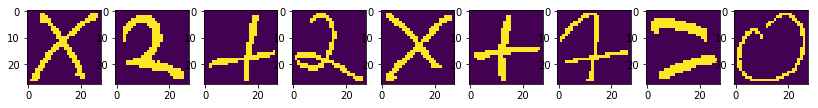

In [12]:
figure(figsize=(14,14))

size = X_data.shape[0]
for i in range(size):
    v = X_data[i][:,:,0].astype('uint8')
    img = Image.fromarray(v)
    
    plt.subplot(2, size, i + 1)
    plt.imshow(img)

In [13]:
df = pd.read_csv(mapping_processed)
code2char = {}
for index, row in df.iterrows():
    code2char[row['id']] = row['char']

In [18]:
model = load_model(MODEL_PATH)

In [15]:
# predict results
results = model.predict(X_data)

# select the index with the maximum probability
results = np.argmax(results, axis = 1)
parsed_str = ""
for r in results:
    parsed_str += code2char[r]

parsed_str

'X2+2Xtf=0'

In [16]:
def score(pred, label):
    res = 0
    for i in range(len(pred)):
        res += pred[i] == label[i]
        
    print('{}, score={}'.format(pred, res))

In [17]:
label = 'X2+2X+7=0'
score('X2t2Xt+=0', label)
score('X2t2Xt+20', label)
score('X2+2Xtg=0', label)
score('X2+2Xtf=0', label)
score('X2+2Xtq=0', label)

X2t2Xt+=0, score=6
X2t2Xt+20, score=5
X2+2Xtg=0, score=7
X2+2Xtf=0, score=7
X2+2Xtq=0, score=7
